# Colloborative filtering workflow

In [1]:
import numpy as np
import pandas as pd
import random
import statistics
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, save_npz, load_npz
from sklearn.cluster import KMeans
from collections import defaultdict
from surprise import Dataset
from surprise import Reader
from surprise import BaselineOnly, Dataset, Reader, SVD, KNNBasic, KNNBaseline, KNNWithMeans, dump
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from model.CollaborativeFilteringRec import cf_model_class, train_cf_models
from evaluation.Evaluate import Evaluate

## Data preprocessing

In [3]:
# preprocess and save data for collaborative filtering modelling
from data_script.preprocess_collaborative import hamid_user_id, sveta_user_id, anti_hamid_user_id, anti_sveta_user_id

Creating dataframes...
Filtering users...
Out of total of  138493  users,  64051  are considered lazy and will be removed.
The final number of users is  74442
Randomly choosing 1000 users...
Adding Sviatlana's and Hamid's ratings... we are lazy users, but still...
Sveta 's user id is 116793
Hamid 's user id is 65601
Adding anti-Sviatlana's and anti-Hamid's ratings... they are lazy users, but still...
anti-Sveta 's user id is 112045
anti-Hamid 's user id is 27936
Now, the final number of users is  1004
Filtering movies...
Out of total of  9434  movies,  8827  are considered rare and will be removed.
The final number of movies is  607
Creating the pivot matrix...
The resulting sparcity of the matrix is: 0.8018732319486469
Preparing the final rating matrix...
Data preprocesssing for collaborative filtering modeling is completed!


## Training CF models

In [2]:
#Get the necessary matrices
print("Getting the ratings matrix...")
ratings = pd.read_csv('./data/processed/final_ratings.csv') #will have the finaly users and movies: to take intoacco
print("Getting the movies dataset...")
movie_df = pd.read_csv('./data/external/movies.csv')
print("Getting the csr matrix...")
csr_util_mat = load_npz("./data/processed/csr_ratings.npz")
print("Getting the utility matrices...")
pivot =  pd.read_csv('./data/processed/pivot.csv')
pivot_na =  pd.read_csv('./data/processed/pivot_na.csv')

Getting the ratings matrix...
Getting the movies dataset...
Getting the csr matrix...
Getting the utility matrices...


In [4]:
pivot.head()

,userId,1,2,3,5,6,7,10,11,16,...,58559,59315,60069,63082,68157,68358,68954,70286,72998,79132
0,3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,69,4.0,0.0,0.0,3.0,4.0,0.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,115,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,3.5
3,348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,3.5,4.0,4.0,4.5,3.5,3.0,4.0
4,358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Normalization of the ratings

In [5]:
def mean_normalization(pivot):
    mat = pivot.copy()
    averages = mat[mat != 0].mean(axis = 1).values
    for i in range(len(mat)):
        # Subtract by mean of each user, not the entire user
        mat.iloc[i,:] = (mat.iloc[i,:] - averages[i]) 
    return averages, mat

pivot_tmp = pivot_na.drop('userId', axis=1)
means, pivot_norm_na = mean_normalization(pivot_tmp)
pivot_norm = pivot_norm_na.fillna(0)
csr_data_norm = csr_matrix(pivot_norm.values)

## Pre-clustering users

In [6]:
# preprocess and save data for collaborative filtering modelling
from data_script.clustering_collaborative import kmeans_labels, unique_labels, label_counts, ratings_clusters, getUserClusterByUserId

Pre-clustering users with K-means with 15 clusters
Getting the csr matrix...
Getting the utility matrices...
Getting the ratings matrix...
The number of users per class:

0 137
1 195
2 110
3 421
4 141
Creating rating matrices for each cluster...


In [7]:
# create models for each cluster
def train_clusters(ratings_clusters):
    models = []
    rmse = []
    for i in range(len(ratings_clusters)):
        print('Training model for cluster', i, '...')
        reader = Reader(rating_scale=(0.5, 5))
        data = Dataset.load_from_df(ratings_clusters[i][["userId", "movieId", "rating"]], reader)
        #Prepare train and test data (what about validation?)
        #trainset, testset = train_test_split(data, test_size=.25, random_state=42)
        # For final preditions
        trainset = data.build_full_trainset()
        testset = trainset.build_anti_testset()
        svd = SVD()
        svd_model = cf_model(svd, trainset, testset, data, 20)
        svd_model.fit_and_predict()
        #rmse.append(svd_model.cross_validate())
        models.append(svd_model)
    return models, rmse

In [8]:
# Get models and RMSE for each model
models, rmse = train_clusters(ratings_clusters)

Training model for cluster 0 ...
RMSE: 0.4232
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Compu

In [9]:
randomuser1 = random.sample(ratings["userId"].value_counts().index.to_list(), 1)[0]
randomuser2 = random.sample(ratings["userId"].value_counts().index.to_list(), 1)[0]

print(getUserClusterByUserId(sveta_user_id))
print(getUserClusterByUserId(hamid_user_id))
print(getUserClusterByUserId(anti_sveta_user_id))
print(getUserClusterByUserId(anti_hamid_user_id))
print(getUserClusterByUserId(randomuser1))
print(getUserClusterByUserId(randomuser2))


sv_df = ratings_clusters[getUserClusterByUserId(sveta_user_id)]
anti_sv_df = ratings_clusters[getUserClusterByUserId(anti_sveta_user_id)]
hm_df = ratings_clusters[getUserClusterByUserId(hamid_user_id)]
anti_hm_df = ratings_clusters[getUserClusterByUserId(anti_hamid_user_id)]

df_random1 = ratings_clusters[getUserClusterByUserId(randomuser1)]
df_random2 = ratings_clusters[getUserClusterByUserId(randomuser2)]

3
1
3
1
3
3


### Evaluation of KMeans

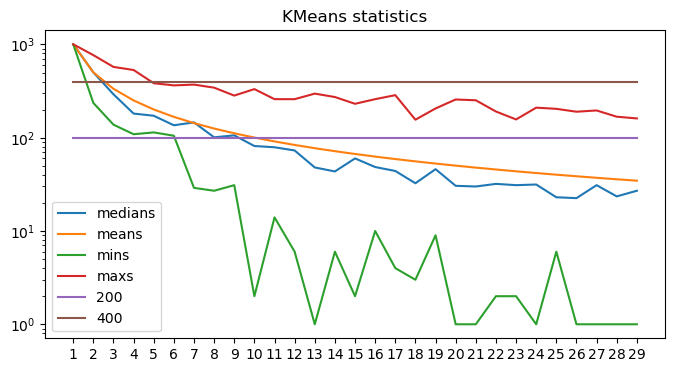

In [10]:
def kmeans_clauster_statistics(data, start, stop, step):
    medians = list()
    means = list()
    mins = list()
    maxs = list()
    x = np.arange(start, stop, step)
    for i in x:
        kmeans = KMeans( init='k-means++', n_clusters=i, algorithm='lloyd', n_init='auto').fit(data)
        labels = kmeans.labels_ 
        unique, counts = np.unique(labels, return_counts=True)
        medians.append(statistics.median(counts))
        means.append(counts.mean())
        mins.append(counts.min())
        maxs.append(counts.max())
        
    plt.figure(figsize=(8, 4))
    plt.title('KMeans statistics')
    plt.plot(x, medians, label='medians')
    plt.plot(x, means, label='means')
    plt.plot(x, mins, label='mins')
    plt.plot(x, maxs, label='maxs')
    plt.plot(x, 100 * np.ones(len(x)) , label='200')
    plt.plot(x, 400 * np.ones(len(x)) , label='400')
    plt.xticks(x)
    plt.yscale('log')
    plt.legend()
    plt.show()
        
    return medians, means, mins, maxs

medians, means, mins, maxs  = kmeans_clauster_statistics(csr_util_mat, start = 1, stop = 30, step = 1)

In [11]:
from metric.ElbowMethod import elbowMethod 
from metric.silhouette_score import SilhouetteAnalyzer 

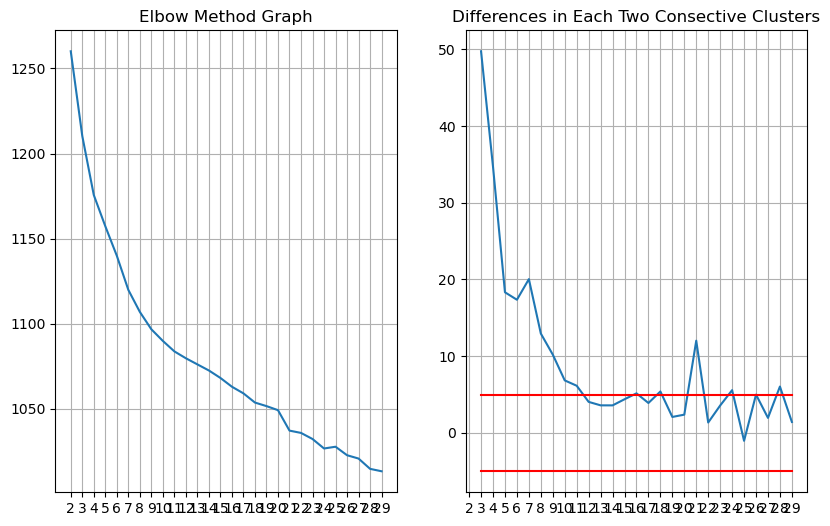

In [12]:
elb = elbowMethod(csr_util_mat)
elb.run(Start=2, Stop=30, Step=1)
elb.showPlot()


In [13]:
sil = SilhouetteAnalyzer(pivot)
sil.run(start=2, stop=20, step=1, max_iterations=300)

In [14]:
# As it takes a really long tile to copute the silhouette score, lets save the results to a file:
from numpy import save
from numpy import load
save('./metric/cf_s_scores.npy', sil.s_scores)
save('./metric/cf_clusters.npy', sil.clusters)
data = load('./metric/cf_clusters.npy')
print(data)

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


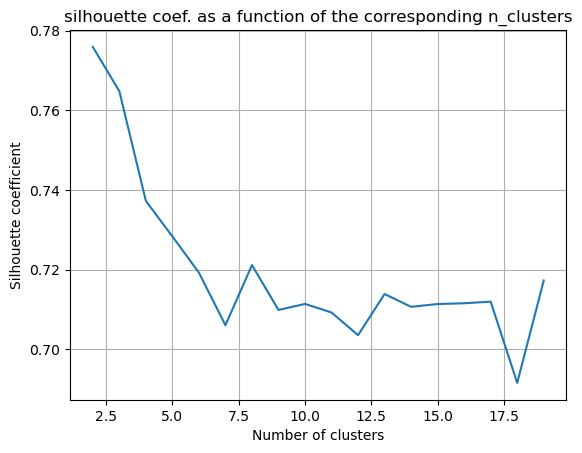

In [15]:
sil.showPlot()

## Prepare data in the Surprise's format

In [3]:
print("Preparing data in the Suprise format...")
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

#Prepare train and test data (what about validation?)
#trainset, testset = train_test_split(data, test_size=.25, random_state=42)

# For final preditions
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

Preparing data in the Suprise format...


In [10]:
pivot.head()

,userId,1,2,3,6,7,10,11,16,17,...,56367,58559,59315,60069,63082,68157,68954,70286,72998,79132
0,11,4.5,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,31,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,5.0,5.0,4.5,0.5,0.0,3.0,4.0,4.5,0.0
2,283,0.0,0.0,0.0,4.0,0.0,3.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,372,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,387,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,4.5,...,0.0,0.0,3.5,0.0,0.0,4.0,0.0,0.0,3.5,0.0


## Training model (KNN Pearson) for providing weights for CF un hybrid setup

In [4]:
#KNN-based memory based model
sim_options = {'name': 'pearson',
               'min_support': 30,
               'user_based': True}

knn_pearson = KNNBasic(k=30,sim_options=sim_options)

knn_pearson.fit(trainset)
predictions = knn_pearson.test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [5]:
knn_basic_pearson_model = cf_model_class(predictions, knn_pearson)

## KNN Basic

In [6]:
#KNN-based memory based model
sim_options = {'name': 'msd',
               'min_support': 3,
               'user_based': True}

knn_basic = KNNBasic(k=25,sim_options=sim_options)
knn_basic.fit(trainset)
knn_basic_predictions = knn_basic.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [7]:
knn_basic_model = cf_model_class(knn_basic_predictions, knn_basic)
knn_basic_model.fit_and_predict()

Getting the ratings matrix...
Preparing data in the Suprise format...
Done calculating predictions!


In [ ]:
knn_basic_model.cross_validate()

In [ ]:
knn_basic_model.recommend_all(sveta_user_id).merge(movie_df, on='movieId', how='left').head(20)

In [ ]:
knn_basic_model.recommend_all(hamid_user_id).merge(movie_df, on='movieId', how='left').head(20)

## KNN With Means

In [12]:
sim_options = {'name': 'pearson',
               'min_support': 30,
               'user_based': True}

knn_with_means = KNNWithMeans(k=30,sim_options=sim_options)

In [ ]:
knn_with_means_model = cf_model_class(knn_with_means, trainset, testset, data, 20)
knn_with_means_model.fit_and_predict()

In [ ]:
knn_with_means_model.cross_validate()

In [ ]:
dump.dump('model/trained_models/KNNWithMeans_Model',algo=knn_with_means_model,predictions=knn_with_means_model.pred_test)

In [ ]:
knn_with_means_model.recommend_all(sveta_user_id).merge(movie_df, on='movieId', how='left').head(20)

In [ ]:
knn_with_means_model.recommend_all(hamid_user_id).merge(movie_df, on='movieId', how='left').head(20)

## SVD default

In [ ]:
# Retrain the model
svd = SVD()
svd_model = cf_model(svd, trainset, testset, data, 20)
svd_model.fit_and_predict()

In [ ]:
svd_model.cross_validate()

In [ ]:
dump.dump('model/trained_models/SVDDefault_Model',algo=svd_model,predictions=svd_model.pred_test)

In [ ]:
svd_model.recommend_all(sveta_user_id).merge(movie_df, on='movieId', how='inner').head(20)

In [ ]:
svd_model.recommend_all(hamid_user_id).merge(movie_df, on='movieId', how='inner').head(20)

## SVD tuned

In [ ]:
param_grid = {
    'n_factors': [10, 50, 90],
    'n_epochs': [5, 20, 50], 
    'lr_all': [0.001, 0.005, 0.02],
    'reg_all': [0.005, 0.02, 0.1]}

gs = GridSearchCV(SVD, param_grid, measures=['mae'], cv=3, n_jobs = -1)
gs.fit(data)
params = gs.best_params['mae']
svdtuned = SVD(n_factors=params['n_factors'], n_epochs=params['n_epochs'],lr_all=params['lr_all'], reg_all=params['reg_all'])
svdtuned.fit(trainset)
svdtuned_predictions = svdtuned.test(testset)

In [ ]:
dump.dump('model/trained_models/SVDTuned_Model',algo=svdtuned,predictions=svdtuned_predictions)

In [ ]:
params

In [ ]:
svd_tuned_model = cf_model(svdtuned, trainset, testset, data, 20)
svd_tuned_model.fit_and_predict()

In [ ]:
svd_tuned_model.cross_validate()

In [ ]:
svd_tuned_model.recommend_all(sveta_user_id).merge(movie_df, on='movieId', how='inner').head(20)

In [ ]:
svd_tuned_model.recommend_all(anti_sveta_user_id).merge(movie_df, on='movieId', how='inner').head(20)

## Calculation of the quality of the collaborative filtering

 **Variety**

In [ ]:
eval_knn_basic = Evaluate(knn_basic_model)
eval_knn_basic.Variety()

In [ ]:
eval_knn_wmeans = Evaluate(knn_with_means_model)
eval_knn_wmeans.Variety()

In [ ]:
eval_svd = Evaluate(svd_model)
eval_svd.Variety()

In [ ]:
eval_tuned_svd = Evaluate(svd_tuned_model)
eval_tuned_svd.Variety()

## Analysis of similarity matrices

In [9]:
simMat_knn_basic = knn_basic.compute_similarities()
#simMat_knn_with_means = knn_with_means_model.compute_similarities()
simMat_knn_pearson = knn_pearson.compute_similarities()

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


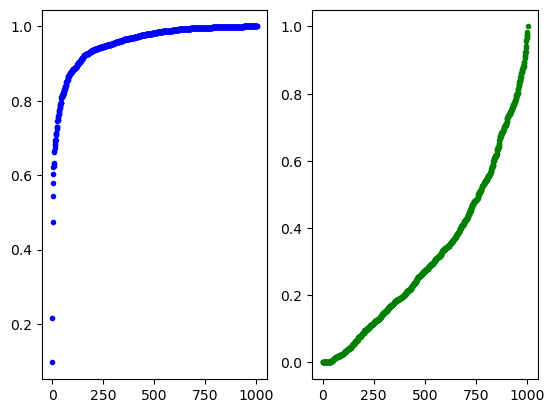

In [10]:
a = np.empty(len(simMat_knn_basic))
for i in range(len(simMat_knn_basic)):
    a[i] = (simMat_knn_basic[i] > 0).sum() -1
    
b = np.empty(len(simMat_knn_pearson))
for i in range(len(simMat_knn_pearson)):
    b[i] = (simMat_knn_pearson[i] > 0).sum() -1

fig=plt.figure()
ax=fig.add_subplot(121)
ax.plot(range(len(simMat_knn_basic)), np.sort(a)/np.sort(a).max(), "b.", linewidth=0.2, label="result_knn_with_means")
ax=fig.add_subplot(122)
ax.plot(range(len(simMat_knn_pearson)), np.sort(b)/np.sort(b).max(), "g.", linewidth=0.2, label="result_knn_with_means")
    

In [ ]:
def sim_matrices_info(dict_of_matrices):
    df = pd.DataFrame(columns=['mean'], index=dict_of_matrices.keys())
    df['mean'] =  [x.mean() for x in dict_of_matrices.values()]
    return df

In [ ]:
sim_matrices_info({'knn_basic': simMat_knn_basic, 'knn_with_means': simMat_knn_with_means, 'knn_pearson' :simMat_knn_pearson})

In [ ]:
import seaborn as sns
sns.heatmap(simMat_knn_basic)

In [ ]:
sns.heatmap(simMat_knn_with_means)

## Factorisation for hybrid model


**Personalization**

In [ ]:
def compute_prediction_overlap(userId_1, userId_2, model):
    overlap_array = []
    rec_1 = set(model.recommend_all(userId_1).movieId.values[:50])
    rec_2 = set(model.recommend_all(userId_2).movieId.values[:50])
    overlap = rec_1 
    return len(rec_1.intersection(rec_2))

def return_similarities(userId, model, simMat):
    df = pd.DataFrame(columns=["uuid", "similarity", "overlap"])
    uuid = model.trainset.to_inner_uid(userId)
    sim_array = simMat[uuid]
    uuid_array = np.arange(simMat.shape[0])
    df["uuid"] = uuid_array
    df["similarity"] = sim_array
    df["overlap"] = df.apply(lambda x: compute_prediction_overlap(userId, model.trainset.to_raw_uid(x["uuid"]), model), axis=1)
    return df.sort_values(by=["similarity"]).reset_index(drop=True)

def return_sims_above_threshold(similarities_df, threshold):
    return len(similarities_df[similarities_df.similarity > threshold])


In [ ]:
hamid_user_id, sveta_user_id, anti_hamid_user_id, anti_sveta_user_id

In [ ]:
random_user = np.random.choice(ratings.userId.unique())  

In [ ]:
random_user = np.random.choice(ratings.userId.unique())  
result_knn_with_means = return_similarities(random_user, knn_with_means_model, simMat_knn_with_means)
print(return_sims_above_threshold(result_knn_with_means , 0))
#result_knn_basic = return_similarities(random_user, knn_basic_model, simMat_knn_basic )
#result_knn_pearson = return_similarities(random_user, knn_pearson_model, simMat_knn_pearson )

#plt.grid(True)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(result_knn_with_means.similarity, result_knn_with_means.overlap, "b.", linewidth=0.2, label="result_knn_with_means")
ax.set_xlim(xmin=-1, xmax=1)

In [ ]:
#result_svd_means = return_similarities(random_user, svd_model, simMat_knn_with_means )
result_svd_basic = return_similarities(random_user, svd_model, simMat_knn_basic )
#result_svd_tuned_means = return_similarities(random_user, svd_tuned_model, simMat_knn_with_means )
#result_svd_tuned_basic = return_similarities(random_user, svd_tuned_model, simMat_knn_basic )
#result_svd_tuned_pearson = return_similarities(random_user, svd_tuned_model, simMat_knn_pearson )

In [ ]:
result_anti_hamid_df = return_similarities(anti_hamid_user_id, svd_model, simMat_knn_with_means)
result_hamid_df = return_similarities(hamid_user_id, svd_model, simMat_knn_with_means)


In [ ]:
#plt.plot(result_svd_means.similarity, result_svd_means .overlap, "b*", linewidth=0.2, label="result_svd_means ")
#plt.plot(result_svd_basic.similarity, result_svd_basic.overlap, "m*", linewidth=0.2, label="result_svd_basic")
#plt.plot(result_svd_tuned_basic.similarity, result_svd_tuned_basic.overlap, "y*", linewidth=0.2, label="result_svd_tuned_basic")
#plt.plot(result_svd_tuned_means.similarity, result_svd_tuned_means.overlap, "c*", linewidth=0.2, label="result_svd_tuned_with_means")
#plt.plot(result_svd_tuned_pearson.similarity, result_svd_tuned_pearson.overlap, "k.", linewidth=0.2, label="result_svd_tuned_pearson")
plt.plot(result_knn_with_means.similarity, result_knn_with_means.overlap, "b.", linewidth=0.2, label="result_knn_with_means")
#plt.plot(result_knn_basic.similarity, result_knn_basic.overlap, "g*", linewidth=0.2, label="result_knn_basic")
#plt.plot(result_knn_pearson.similarity, result_knn_pearson.overlap, "r.", linewidth=0.9, label="result_knn_pearson")
plt.xlabel('Similarity')
plt.ylabel('Overlap')

plt.legend()
plt.xlim=(0,1)
plt.show()

## Upload trained models and their predictions

In [ ]:
knn_basic_preds, knn_basic_algo = dump.load('./model/trained_models/KNNBasic_Model')
knn_basic_model = cf_model(knn_basic_algo, trainset, testset, data, 10, knn_basic_preds)
knn_basic_model.fit_and_predict()

In [ ]:
knn_wmeans_preds, knn_wmeans_algo = dump.load('./model/trained_models/KNNWithMeans_Model')
knn_with_means_model = cf_model(knn_wmeans_algo, trainset, testset, data, 10, knn_wmeans_preds)
knn_with_means_model.fit_and_predict()

In [ ]:
svd_preds, svd_algo = dump.load('./model/trained_models/SVDDefault_Model')
svd_model = cf_model(svd_algo, trainset, testset, data, 10, svd_preds)
svd_model.fit_and_predict()